# Package loading and basic configurations

In [1]:
%load_ext autoreload
%autoreload 2

# load dependencies'
import matplotlib.pyplot as plt
import scipy
from scipy.misc import derivative
import datetime
import numpy as np
import pandas as pd
import geopandas as gpd
from envirocar import TrackAPI, DownloadClient, BboxSelector, TimeSelector, ECConfig

# create an initial but optional config and an api client
config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))

# Querying enviroCar Tracks

The following cell queries tracks from the enviroCar API. It defines a bbox for the area of Münster (Germany) and requests 50 tracks in the time interval. 

In [2]:
bbox = BboxSelector([
    7.603312, # min_x
    51.952343, # min_y
    7.65083, # max_x 
    51.974045,  # max_y 
])


# issue a query
track_df = track_api.get_tracks(bbox=bbox,  num_results=5) # requesting 50 tracks inside the bbox


## Define car parameters

In [126]:
#Define General Parameters

P_air = 1.2   # Air mass density "kg per m³" 
P_idle = 2    # Idle power "kW"
Cw = 0.3      # Air drag cofficient 
H_g = 8.8     # Calorific value gasoline "kWh/l"
H_d = 9.9     # Calorific value diesel "kWh/l"
g = 9.81      # Gravitational acceleration "m/s²"
efc = 0.30    # efficiency constant value from Literature 0.25 - 0.35

#Define Car parameters
class Car:
    def __init__(self,m=1500,A=2,Cw=0.3):
        self.m = m
        self.A = A
        self.Cw = Cw

##  Define specific paramerer by class (Volkswagen)
volks = Car(1570,2.179,0.32)
##generalcar = car
car = Car()


## Different functions (distance, gradient, speed equation, fuel consumption, engine power)

In [127]:
def distance(lon1,lon2,lat1,lat2):
    R = 6370000 #radius
    φ1=lat1 * np.pi /180
    φ2 = lat2 * np.pi /180
    Δφ = (lat2-lat1) * np.pi /180
    Δλ = (lon2-lon1) * np.pi /180
    a = np.sin(Δφ/2) * np.sin(Δφ/2) +np.cos(φ1) * np.cos(φ2) *np.sin(Δλ/2) * np.sin(Δλ/2)
    c = 2*np.arctan2(np.sqrt(a), np.sqrt(1-a));
    return R * c

def gradient(height,distance):
    return np.arctan(height/distance) * 180/np.pi

#Get speed equation
def get_equation(x,y):
    degree = 80
    coefs, res, _, _, _ = np.polyfit(x,y,degree, full = True)
    ffit = np.poly1d(coefs)
    #print (ffit)
    return ffit

def fuel_consumption(eng_pow, H_fuel, efc):
    consumption = eng_pow / (H_fuel * efc)
    return consumption

## Define engine power (KW)
def engine_power(car,Cr,gradient,speed,acceleration):
    if speed > 0:
        power =speed*(0.5*car.Cw*car.A*P_air*pow(speed,2) #driving resistance
                      +car.m*g*Cr*np.cos(gradient) #rolling resistence
                      +car.m*g*np.sin(gradient) # climbing resistance
                      +car.m*+acceleration) # inertial resistance
        return [power/1000]
    else:
        return [P_idle]




## Estimate fuel consumption/Co2 emissions for all tracks

In [128]:
tracks = pd.DataFrame(columns=track_df.columns)
for i in range (1,4):
    one_track_id = track_df['track.id'].unique()[i]
    one_track = track_df[track_df['track.id'] == one_track_id]
    for i in one_track.index:
        if (i == len(one_track)-1):
            break
        lat1= one_track.loc[i,'geometry'].y
        lat2= one_track.loc[i+1,'geometry'].y
        lon1= one_track.loc[i,'geometry'].x
        lon2= one_track.loc[i+1,'geometry'].x
        heightdiff = one_track.loc[i+1,'GPS Altitude.value'] - one_track.loc[i,'GPS Altitude.value']
        one_track.loc[i+1,'seg_distance']= distance(lon1,lon2,lat1,lat2)
        grade = gradient(heightdiff,one_track.loc[i+1,'seg_distance'])
        if grade > 0.46:
            one_track.loc[i,'gradient']= 0.35
        elif grade < -1:
            one_track.loc[i,'gradient']= -0.35
        else:
            one_track.loc[i,'gradient']= grade
    ## Add interval time
    j = 5
    for i in one_track.index:
        one_track.loc[i, 'time_interval'] = j
        j = j+5
    # Convert the speed unit to m/s
    for i in one_track.index:
        one_track.loc[i, 'speed'] = one_track.loc[i, 'GPS Speed.value'] * 0.27777
    ## get the speed equation
    #one_track.fillna(0)
    time_interval = np.array(one_track['time_interval'])
    speed = np.array(one_track['speed'])
    idx = np.isfinite(time_interval) & np.isfinite(speed)
    speed_equation = get_equation(time_interval[idx], speed[idx])
    for i in one_track.index:
        if one_track.loc[i, 'speed'] == 0:
            one_track.loc[i, 'Acceleration'] = 0
        else:
            one_track.loc[i, 'Acceleration'] = derivative(speed_equation, one_track.loc[i, 'time_interval'])
    ## Calculates Engine Power for general car
    for i in one_track.index:
        ep = engine_power(car,0.02,one_track.gradient[i],one_track.speed[i],one_track.Acceleration[i])
        if ep[0] < 0:
            one_track.loc[i, 'engine_power'] = P_idle
        else:
            one_track.loc[i, 'engine_power'] = ep[0]
    #Calculates Engine Power for Volks
    for i in one_track.index:
        ep = engine_power(volks,0.02,one_track.gradient[i],one_track.speed[i],one_track.Acceleration[i])
        if ep[0] < 0:
            one_track.loc[i, 'eng_pw_volks'] = P_idle
        else:
            one_track.loc[i, 'eng_pw_volks'] = ep[0]
            
    ## Fuel consumption/CO2 emissions for General car (gasoline)
    for i in one_track.index:
        car_cons = fuel_consumption(one_track.engine_power[i],H_g, efc) 
        one_track.loc[i, 'Consumption_Gasoline'] = car_cons   ## liters / hour
        one_track.loc[i, 'CO2_Gasoline'] = car_cons * 2.39      ## kg Co2 / hour

    
    ## Fuel consumption/CO2 emissions for for Volks (diesel)
    for i in one_track.index:
        volks_cons = fuel_consumption(one_track.eng_pw_volks[i],H_d, efc) 
        one_track.loc[i, 'Consumption_volks_diesel'] = volks_cons    ## liters / hour
        one_track.loc[i, 'CO2_volks_diesel'] = volks_cons * 2.69     ## kg Co2 / hour
    
    tracks = pd.concat([tracks, one_track])

In [129]:
tracks

,id,time,geometry,Intake Pressure.value,Intake Pressure.unit,GPS Bearing.value,GPS Bearing.unit,Throttle Position.value,Throttle Position.unit,Consumption.value,...,gradient,time_interval,speed,Acceleration,engine_power,eng_pw_volks,Consumption_Gasoline,CO2_Gasoline,Consumption_volks_diesel,CO2_volks_diesel
0,5eb7582c65b80c5d6be6b013,2020-05-09T23:45:27,POINT (7.619238953523779 51.9746148909074),53.000002,kPa,265.758515,deg,16.999999,%,3.532256,...,-0.350000,5.0,14.461278,0.012516,2.000000,2.000000,0.757576,1.810606,0.673401,1.811448
1,5eb7582c65b80c5d6be6b015,2020-05-09T23:45:32,POINT (7.618198085684507 51.97455379688843),70.000000,kPa,264.226218,deg,19.999999,%,4.613204,...,-0.350000,10.0,14.187977,0.003284,2.000000,2.000000,0.757576,1.810606,0.673401,1.811448
2,5eb7582c65b80c5d6be6b016,2020-05-09T23:45:37,POINT (7.617130694367564 51.97449045607679),71.000002,kPa,264.665323,deg,20.000001,%,4.988681,...,0.000002,15.0,15.087903,-0.004583,5.573621,5.976496,2.111220,5.045816,2.012288,5.413056
3,5eb7582c65b80c5d6be6b017,2020-05-09T23:45:42,POINT (7.615983411612011 51.97443994404965),70.613516,kPa,266.438552,deg,20.000000,%,5.218309,...,-0.350000,20.0,15.731909,-0.011184,2.000000,2.000000,0.757576,1.810606,0.673401,1.811448
4,5eb7582c65b80c5d6be6b018,2020-05-09T23:45:47,POINT (7.614819814007321 51.97438690248661),25.223188,kPa,266.675224,deg,15.000000,%,1.829419,...,-0.721758,25.0,15.685422,-0.016613,2.000000,2.000000,0.757576,1.810606,0.673401,1.811448
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,5eb7582165b80c5d6be6a1ae,2020-05-09T08:21:15,POINT (7.651989999238601 51.95400700811021),40.000000,kPa,258.657484,deg,15.000000,%,1.636909,...,-0.350000,530.0,2.993958,-0.266485,2.000000,2.000000,0.757576,1.810606,0.673401,1.811448
106,5eb7582165b80c5d6be6a1af,2020-05-09T08:21:20,POINT (7.651829345262824 51.95399070884194),41.000000,kPa,265.042975,deg,14.000000,%,1.601665,...,0.000000,535.0,1.292451,-0.350577,2.000000,2.000000,0.757576,1.810606,0.673401,1.811448
107,5eb7582165b80c5d6be6a1b0,2020-05-09T08:21:25,POINT (7.651801770552993 51.95398047687347),41.000000,kPa,0.000000,deg,14.000000,%,1.569227,...,0.000000,540.0,0.000000,0.000000,2.000000,2.000000,0.757576,1.810606,0.673401,1.811448
108,5eb7582165b80c5d6be6a1b1,2020-05-09T08:21:30,POINT (7.651801770552993 51.9539804616943),41.000000,kPa,0.000000,deg,14.000000,%,1.608655,...,0.000786,545.0,0.000000,0.000000,2.000000,2.000000,0.757576,1.810606,0.673401,1.811448


## Filter the data

In [130]:
## filter attributes for all tracks 
all_tracks = tracks[['time', 'speed', 'time_interval', 'Acceleration', 'gradient', 'engine_power', 'eng_pw_volks', 'Consumption_Gasoline','CO2_Gasoline','Consumption_volks_diesel','CO2_volks_diesel' ]]

## filter attributes for one track
one_track_id = tracks['track.id'].unique()[2]
track = tracks[tracks['track.id'] == one_track_id]

one_track = track[['time', 'speed', 'time_interval', 'Acceleration', 'gradient', 'engine_power', 'eng_pw_volks', 'Consumption_Gasoline','CO2_Gasoline','Consumption_volks_diesel','CO2_volks_diesel' ]]



## Plot different vriables for one track

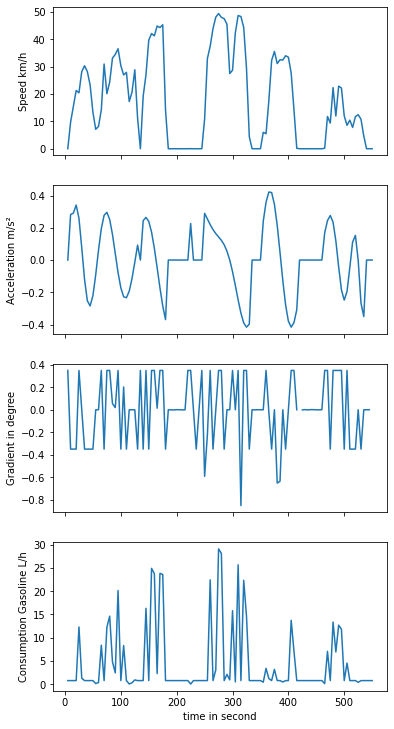

In [132]:
f, axarr = plt.subplots(4, sharex=True)
figsize=(8, 6)
time_interval = np.array(one_track['time_interval'])
speed = np.array(one_track['speed']) / 0.27777
acceleration = np.array(one_track['Acceleration'])
Consumption_Gasoline = np.array(one_track['Consumption_Gasoline'])
gradient = np.array(one_track['gradient'])
#engine_power = np.array(realistc_drive['engine_power']) 



axarr[0].plot(time_interval , speed)
axarr[1].plot(time_interval , acceleration)
axarr[2].plot(time_interval , gradient)
axarr[3].plot(time_interval , Consumption_Gasoline)
#axarr[4].plot(time_interval , engine_power)


axarr[3].set_xlabel('time in second')
axarr[0].set_ylabel('Speed km/h')
axarr[1].set_ylabel('Acceleration m/s²')
axarr[2].set_ylabel('Gradient in degree')
#axarr[3].set_ylabel('Engine Power Kw')
axarr[3].set_ylabel('Consumption Gasoline L/h')


plt.subplots_adjust(top=2.5)
filename = "E:\\Munster\\Floating Car\\Group Assignmnet 2\\fcda.png"
plt.savefig(filename, format= 'png', bbox_inches='tight' )

## Import OSM Network, in the same area of tracks

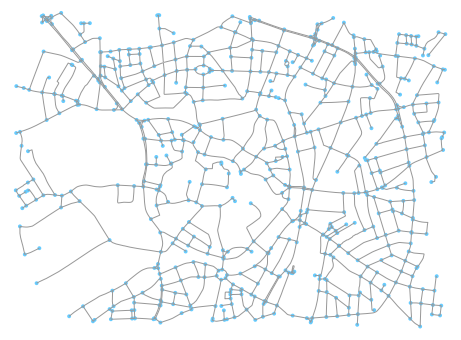

(<Figure size 576.497x432 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1e4776655c8>)

In [243]:
import osmnx as ox

G = ox.graph_from_bbox(51.974045, 51.952343, 7.65083, 7.603312, network_type='drive')
G_projected = ox.project_graph(G)
ox.plot_graph(G_projected)

## Convert the OSM Netwok to geodataframe and filter the attributes

In [260]:
nodes, streets = ox.graph_to_gdfs(G)
road_network = streets[['maxspeed','length','surface']]
road_network
#to check the type of surface "for rolling coff."
for i in road_network.index:
    if road_network.loc[i, 'surface'] == "asphalt":
        road_network.loc[i, 'rolling_resistance'] = 0.02 # source: engineeringtoolbox.com
    elif road_network.loc[i, 'surface'] == "cobblestone":
        road_network.loc[i, 'rolling_resistance'] = 0.015 # source: engineeringtoolbox.com
    elif road_network.loc[i, 'surface'] == "paving_stones":
        road_network.loc[i, 'rolling_resistance'] = 0.033 # source: The Automotive Chassis book
    else:
        road_network.loc[i, 'rolling_resistance'] = 0.02
        
road_network

,maxspeed,length,surface,rolling_resistance
0,50,6.146,asphalt,0.02
1,50,200.247,asphalt,0.02
2,30,12.933,asphalt,0.02
3,50,96.147,asphalt,0.02
4,NaN,119.161,asphalt,0.02
...,...,...,...,...
915,30,68.594,asphalt,0.02
916,30,56.319,asphalt,0.02
917,NaN,56.935,NaN,0.02
918,30,81.071,asphalt,0.02
